In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt

import os 
import uproot, uproot_methods
import uproot_methods.classes.TLorentzVector as TLorentzVector
import uproot_methods.classes.TVector3 as TVector3

import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/higgsReconstruction/')
from JetCons import JetCons

In [3]:
#bkgFile = pd.read_hdf('/home/btannenw/Desktop/ML/anomalyDetection/lhcOlympics2020/events_LHCO2020_backgroundMC_Pythia.h5', stop=400)
#blackBox1 = pd.read_hdf('/home/btannenw/Desktop/ML/lhcOlympics2020/events_LHCO2020_BlackBox1.h5', stop=400)

topDir_hh  = '/home/btannenw/Desktop/ML/dihiggsMLProject/data/pp2hh4b_25k/'
topDir_qcd = '/home/btannenw/Desktop/ML/dihiggsMLProject/data/ppTo4b_50k/'

allEvents_hh = []
allEvents_qcd = []

for filename in os.listdir(topDir_hh):
    if filename.endswith(".pkl"):
        temp = pkl.load( open( topDir_hh+filename, 'rb' )) 
        allEvents_hh += temp
    else:
        continue
        
for filename in os.listdir(topDir_qcd):
    if filename.endswith(".pkl"):
        temp = pkl.load( open( topDir_qcd+filename, 'rb' )) 
        allEvents_qcd += temp
    else:
        continue

print( len(allEvents_hh), len(allEvents_qcd) )

25000 49978


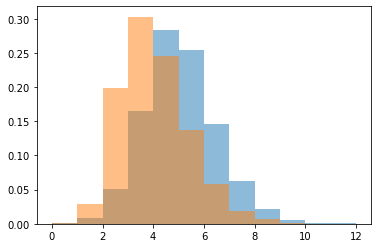

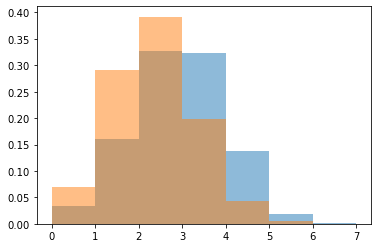

In [4]:
njets_hh = [ x['nJets'] for x in allEvents_hh]
ntags_hh = [ x['nBTags'] for x in allEvents_hh]
njets_qcd = [ x['nJets'] for x in allEvents_qcd]
ntags_qcd = [ x['nBTags'] for x in allEvents_qcd]

plt.hist( njets_hh, bins=12, range=[0,12], alpha=0.5, density=1)
plt.hist( njets_qcd, bins=12, range=[0,12], alpha=0.5, density=1)
plt.show()
plt.hist( ntags_hh, bins=7, range=[0,7], alpha=0.5, density=1)
plt.hist( ntags_qcd, bins=7, range=[0,7], alpha=0.5, density=1)
plt.show()

In [5]:
def returnSinglePhiRapidityPtList( eventList, consLabel ):
    """ return single list of phi, rapidity, pt"""
    
    _consCode = -1
    if consLabel == 'Tracks':
        _consCode = 0
    elif consLabel == 'Neutral Hadrons':
        _consCode = 1
    if consLabel == 'Photons':
        _consCode = 2
    
    _rap = [ constituent[5] for event in eventList for constituent in event['Constituents'] if constituent[6]==_consCode ]
    _phi = [ constituent[3] for event in eventList for constituent in event['Constituents'] if constituent[6]==_consCode ]
    _pt  = [ constituent[1] for event in eventList for constituent in event['Constituents'] if constituent[6]==_consCode ]
    _all = [_phi, _rap, _pt]
    
    return _all


def returnPhiRapidityPtLists( eventList ):
    """ return three lists of phi, rapidity, pt for later plotting """

    _track      = returnSinglePhiRapidityPtList( eventList, 'Tracks')
    _neutralHad = returnSinglePhiRapidityPtList( eventList, 'Neutral Hadrons')
    _photon     = returnSinglePhiRapidityPtList( eventList, 'Photons')    
    
    return _track, _neutralHad, _photon


tracks_hh, neutralHadrons_hh, photons_hh = returnPhiRapidityPtLists( allEvents_hh )
tracks_qcd, neutralHadrons_qcd, photons_qcd = returnPhiRapidityPtLists( allEvents_qcd )

In [6]:
def returnPlotOpts( _consLabel ):
    """ common function for returning plotting opts"""
    
    track_plotOpts  = dict(bins=(33, 33), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.Reds)
    #photon_plotOpts = dict(bins=(33, 33), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.YlGnBu)
    photon_plotOpts = dict(bins=(33, 33), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.Blues)
    nHad_plotOpts   = dict(bins=(33, 33), range=[[-1*np.pi-0.5, np.pi+0.5],[-3.0, 3.0]], cmap=plt.cm.Greens)

    _plotOpts = {}
    if _consLabel == 'Tracks':
        _plotOpts = track_plotOpts
    if _consLabel == 'Photons':
        _plotOpts = photon_plotOpts
    if _consLabel == 'Neutral Hadrons':
        _plotOpts = nHad_plotOpts

    
    return _plotOpts
    

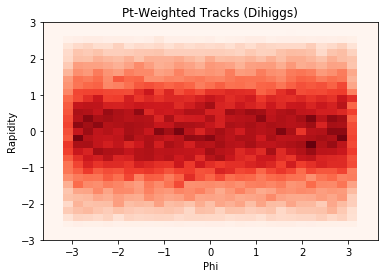

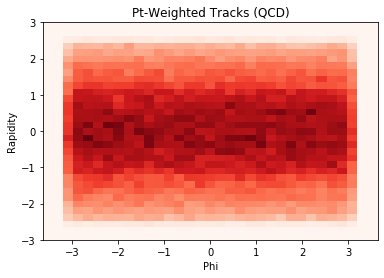

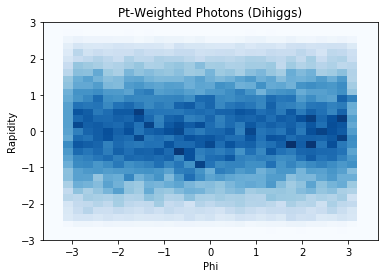

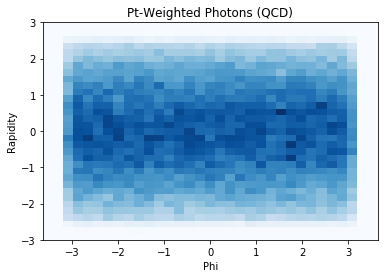

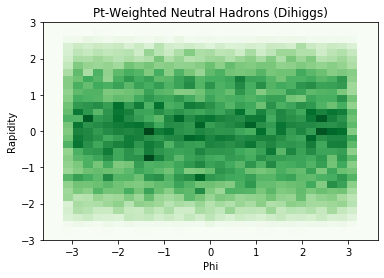

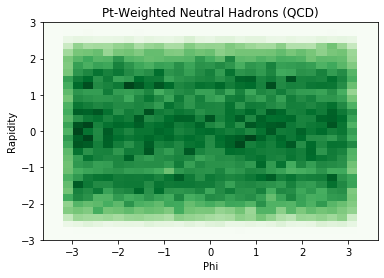

In [7]:
def makeSimplePlots( constituentList, sampleLabel='', consLabel='', nEventsToAverage=-1):
    """ make plots"""
    
    _plotOpts = returnPlotOpts( consLabel )
    _phi = constituentList[0]
    _rap = constituentList[1]
    _pt  = constituentList[2]
    if nEventsToAverage>0:
        _pt = [ constituent/nEventsToAverage for constituent in _pt ]
    
    #plt.hist2d( _phi, _rap, **_plotOpts )
    #plt.title('Raw {} ({})'.format(consLabel, sampleLabel) )
    #plt.xlabel('Phi')
    #plt.ylabel('Rapidity')
    #plt.show()
  
    plt.hist2d( _phi, _rap, weights=_pt, **_plotOpts )
    plt.title('Pt-Weighted {} ({})'.format(consLabel, sampleLabel))
    plt.xlabel('Phi')
    plt.ylabel('Rapidity')
    plt.show()

    return


makeSimplePlots( tracks_hh, 'Dihiggs', 'Tracks')
makeSimplePlots( tracks_qcd, 'QCD', 'Tracks')

makeSimplePlots( photons_hh, 'Dihiggs', 'Photons')
makeSimplePlots( photons_qcd, 'QCD', 'Photons')

makeSimplePlots( neutralHadrons_hh, 'Dihiggs', 'Neutral Hadrons')
makeSimplePlots( neutralHadrons_qcd, 'QCD', 'Neutral Hadrons')

In [10]:
def returnSingleEventPhiRapidityPtList( _event, _consLabel ):
    """ return single list of phi, rapidity, pt"""
    
    # *** 1. Set some collection-dependent variables
    _consCode = -1
    if _consLabel == 'Tracks':
        _consCode = 0
    elif _consLabel == 'Neutral Hadrons':
        _consCode = 1
    if _consLabel == 'Photons':
        _consCode = 2
    
    # *** 1. Get the phi/pt/rapidity from the stored constituents
    _rap = [ constituent[5] for constituent in _event['Constituents'] if constituent[6]==_consCode ]
    _phi = [ constituent[3] for constituent in _event['Constituents'] if constituent[6]==_consCode ]
    _pt  = [ constituent[1] for constituent in _event['Constituents'] if constituent[6]==_consCode ]
    
    # *** 2. Get TLorentzVectors
    _tlv = [JetCons(jc[0], jc[1], jc[2], jc[3], jc[4]).cons_LVec for jc in _event['Constituents']  if jc[6]==_consCode ]
    #v_all = TLorentzVector.PtEtaPhiMassLorentzVector(0,0,0,0)
    #for tlv in allTLVs:
    #    v_all += tlv
    #print("pt: {}, eta: {}, phi: {}, E: {}".format(v_all.pt, v_all.eta, v_all.phi, v_all.E))

    _all = [_phi, _rap, _pt, _tlv]
    
    return _all

def rotateByPhi(_phi, _rotAngle):
    return (((_phi - _rotAngle)+np.pi) % (2*np.pi))-np.pi 

def rotateAndScale( _phi, _rap, _pt, _rotate=False):
    """ scale and rotate inputs """
    
    _scale        = 255/max( _pt )
    _sumWeights   = _scale * len(_pt)
    
    _phi_scaled   = list(np.asarray(_phi)*_scale)
    _rap_scaled   = list(np.asarray(_rap)*_scale)

    #_phi_rot      = [rotateByPhi(x, _phi_centroid) for x in _phi ]
    #_rap_rot      = [rotateByPhi(x, _rap_centroid) for x in _rap ]

    return 
    
def returnRotatedData( _allEvents, _sampleLabel = ''):
    """ Make some event-by-event image plots and also do translation to unified frame """

    final_tracks   = [ [],[],[] ]
    final_nHadrons = [ [],[],[] ]
    final_photons  = [ [],[],[] ]

    for iEvent in range(0, len(_allEvents)):
        #if iEvent > 3:
        #    break
            
        if 100*(iEvent/len(_allEvents))%10 == 0:
            print('{}% Processed'.format(100*(iEvent/len(_allEvents))))
    
        event = _allEvents[ iEvent ]
    
        # protection against events with 0 jets
        if event['nJets'] == 0:
            continue
        
            
        _tracks   = returnSingleEventPhiRapidityPtList( event, 'Tracks')
        _nHadrons = returnSingleEventPhiRapidityPtList( event, 'Neutral Hadrons')
        _photons  = returnSingleEventPhiRapidityPtList( event, 'Photons')
        
        
        # *** Handle pT/ET weights
        _tracks_weights   = [ 1/sum(_tracks[2])   * x for x in _tracks[2] ]
        _nHadrons_weights = [ 1/sum(_nHadrons[2]) * x for x in _nHadrons[2] ]
        _photons_weights  = [ 1/sum(_photons[2])  * x for x in _photons[2] ]
        
        _tracks_sumWeights   = sum( _tracks_weights )
        _nHadrons_sumWeights = sum( _nHadrons_weights )
        _photons_sumWeights  = sum( _photons_weights )
       
        _totalWeights = _tracks_sumWeights + _photons_sumWeights + _nHadrons_sumWeights

    
        # *** Initial CMS calculations
        _tracks_scaled_phi   = [ x*y for x,y in zip(_tracks[0], _tracks_weights)]
        _nHadrons_scaled_phi = [ x*y for x,y in zip(_nHadrons[0], _nHadrons_weights)]
        _photons_scaled_phi  = [ x*y for x,y in zip(_photons[0], _photons_weights)]
        _tracks_scaled_rap   = [ x*y for x,y in zip(_tracks[1], _tracks_weights)]
        _nHadrons_scaled_rap = [ x*y for x,y in zip(_nHadrons[1], _nHadrons_weights)]
        _photons_scaled_rap  = [ x*y for x,y in zip(_photons[1], _photons_weights)]
        _phi_centroid = sum( _tracks_scaled_phi + _nHadrons_scaled_phi + _photons_scaled_phi ) / _totalWeights
        _rap_centroid = sum( _tracks_scaled_rap + _nHadrons_scaled_rap + _photons_scaled_rap ) / _totalWeights
        
        #print("nJets: {}, phi centroid: {}, rap centroid: {}".format(event['nJets'], _phi_centroid, _rap_centroid))
        
        
        # *** Phi Rotation
        _tracks_phi_rot   = [rotateByPhi(x, _phi_centroid) for x in _tracks[0] ]
        _nHadrons_phi_rot = [rotateByPhi(x, _phi_centroid) for x in _nHadrons[0] ]
        _photons_phi_rot  = [rotateByPhi(x, _phi_centroid) for x in _photons[0] ]

        _tracks_scaledRotated_phi   = [ x*y for x,y in zip(_tracks_phi_rot, _tracks_weights)]
        _nHadrons_scaledRotated_phi = [ x*y for x,y in zip(_nHadrons_phi_rot, _nHadrons_weights)]
        _photons_scaledRotated_phi  = [ x*y for x,y in zip(_photons_phi_rot, _photons_weights)]
        _phi_centroid_CM = sum( _tracks_scaledRotated_phi + _nHadrons_scaledRotated_phi + _photons_scaledRotated_phi ) / _totalWeights

        
        # *** Rapidity Boost
        
        # *** Make total 4-vector for CM (center-of-mass)
        v_all         = TLorentzVector.PtEtaPhiMassLorentzVector(0,0,0,0)
        for tlv in _tracks[3]:
            v_all += tlv
        for tlv in _nHadrons[3]:
            v_all += tlv
        for tlv in _photons[3]:
            v_all += tlv
        #print("pt: {}, eta: {}, phi: {}, E: {}".format(v_all.pt, v_all.eta, v_all.phi, v_all.E))

        tlvz  = TLorentzVector.TLorentzVector(0, 0, -1*v_all.p3.z, v_all.t)
        boost_z   = (tlvz.p3/tlvz.p3.mag)*tlvz.beta

        _tracks_rap_boost2   = [ tlv.boost( boost_z).rapidity for tlv in _tracks[3]]
        _nHadrons_rap_boost2 = [ tlv.boost( boost_z).rapidity for tlv in _nHadrons[3]]
        _photons_rap_boost2  = [ tlv.boost( boost_z).rapidity for tlv in _photons[3]]
        
        # y_particle,lab = y_particle,CM + y_CM,lab
        _rap_cm = v_all.rapidity
        _tracks_rap_boost   = [ jc_rap - _rap_cm for jc_rap in _tracks[1]]
        _nHadrons_rap_boost = [ jc_rap - _rap_cm for jc_rap in _nHadrons[1]]
        _photons_rap_boost  = [ jc_rap - _rap_cm for jc_rap in _photons[1]]
    
        _tracks_pt_boost   = [ tlv.boost( boost_z).pt for tlv in _tracks[3]]
        _nHadrons_pt_boost = [ tlv.boost( boost_z).pt for tlv in _nHadrons[3]]
        _photons_pt_boost  = [ tlv.boost( boost_z).pt for tlv in _photons[3]]
        
        for i in range(0, len(_tracks_pt_boost)):
            if (_tracks_pt_boost[i] - _tracks[2][i]) > 0.001:
                print("shit, {} {}".format(_tracks_pt_boost[i] , _tracks[2][i]))

        for i in range(0, len(_tracks_rap_boost)):
            if (_tracks_rap_boost[i] - _tracks_rap_boost2[i]) > 0.001:
                print("shit2, {} {}".format(_tracks_rap_boost[i] , _tracks_rap_boost2[i]))

        _tracks_scaledRotated_rap   = [ x*y for x,y in zip(_tracks_rap_boost, _tracks_weights)]
        _nHadrons_scaledRotated_rap = [ x*y for x,y in zip(_nHadrons_rap_boost, _nHadrons_weights)]
        _photons_scaledRotated_rap  = [ x*y for x,y in zip(_photons_rap_boost, _photons_weights)]
        
        _rap_centroid_CM = sum( _tracks_scaledRotated_rap + _nHadrons_scaledRotated_rap + _photons_scaledRotated_rap ) / _totalWeights
        
        #print("nJets: {}, phi centroid (CM): {}, rap centroid (CM): {}".format(event['nJets'], _phi_centroid_CM, _rap_centroid_CM))
          
        
        final_tracks[0]   += _tracks_phi_rot
        final_tracks[1]   += _tracks_rap_boost
        final_tracks[2]   += _tracks_weights
        final_nHadrons[0] += _nHadrons_phi_rot
        final_nHadrons[1] += _nHadrons_rap_boost
        final_nHadrons[2] += _nHadrons_weights
        final_photons[0]  += _photons_phi_rot
        final_photons[1]  += _photons_rap_boost
        final_photons[2]  += _photons_weights

        
        _plotOpts = returnPlotOpts( 'Tracks' )
    
        if (iEvent <3): 
            plt.hist2d( _tracks[0], _tracks[1], **_plotOpts )
            plt.title('Raw {} Event'.format(_sampleLabel))
            plt.xlabel('Rapidity')
            plt.ylabel('Eta')
            plt.show()
    
            plt.hist2d( _tracks[0], _tracks[1], weights=_tracks[2], **_plotOpts)
            plt.xlabel('Rapidity')
            plt.ylabel('Eta')
            plt.title('Pt-Weighted {} Event'.format(_sampleLabel))
            plt.show()

            plt.hist2d( _tracks[0], _tracks[1], weights=_tracks_weights, **_plotOpts)
            plt.xlabel('Rapidity')
            plt.ylabel('Eta')
            plt.title('Pt-Weighted 2 {} Event'.format(_sampleLabel))
            plt.show()
        
            plt.hist2d( _tracks_phi_rot, _tracks_rap_boost, **_plotOpts)
            plt.title('pt weighted, rot in phi')
            plt.xlabel('Phi')
            plt.ylabel('Eta')
            plt.show()
        
    return final_tracks, final_nHadrons, final_photons

0.0% Processed


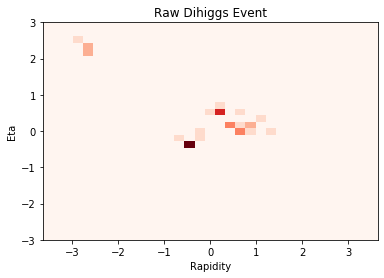

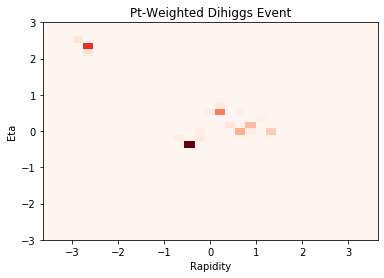

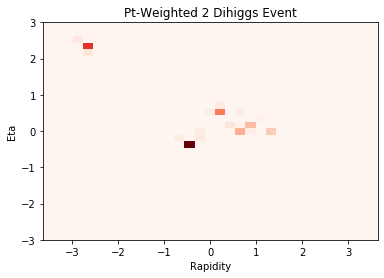

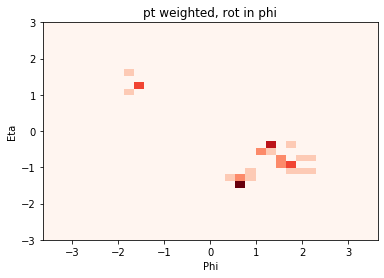

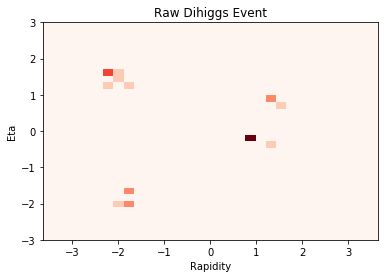

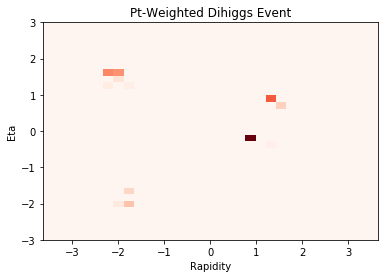

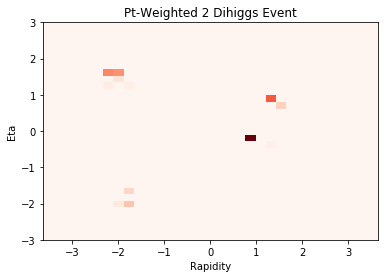

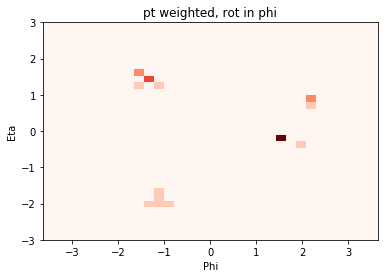

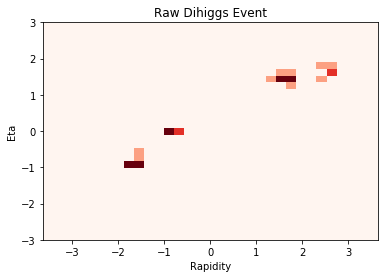

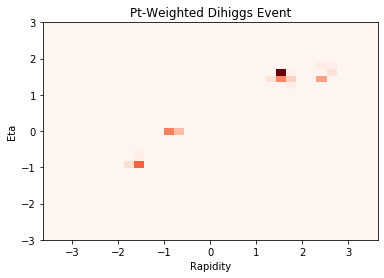

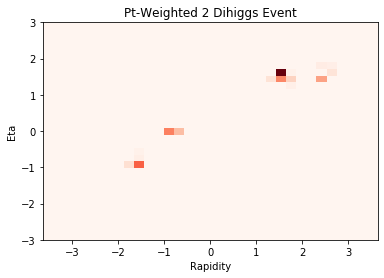

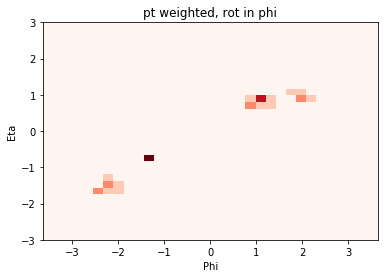

10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed
0.0% Processed


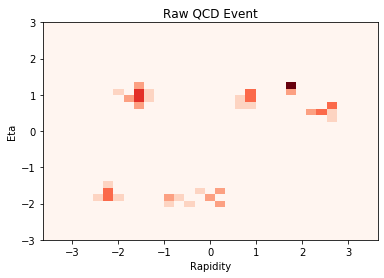

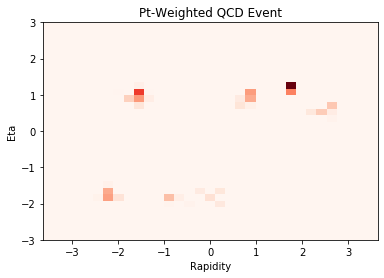

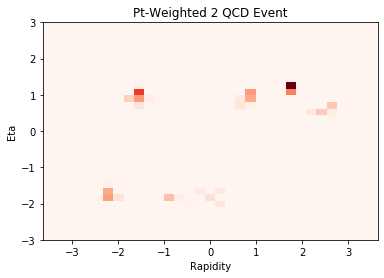

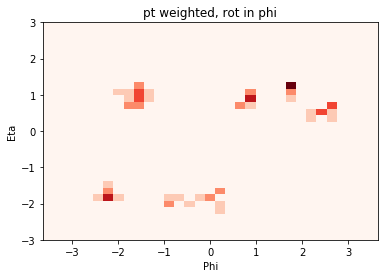

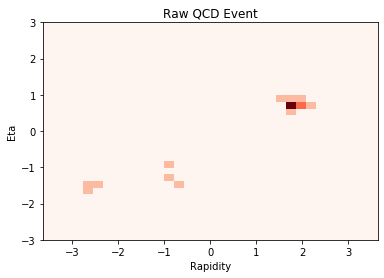

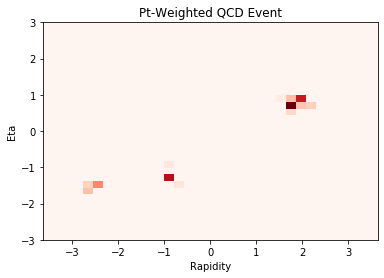

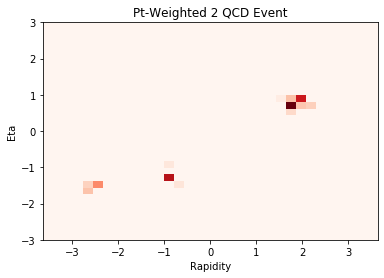

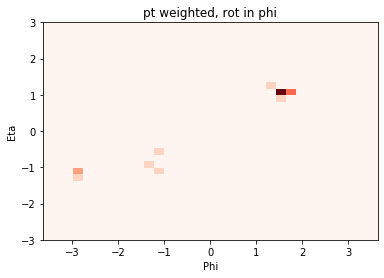

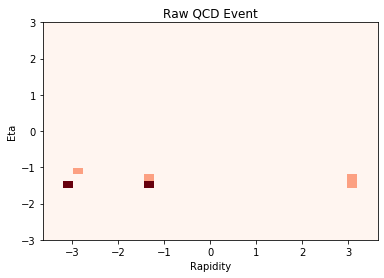

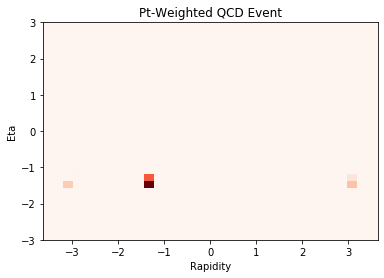

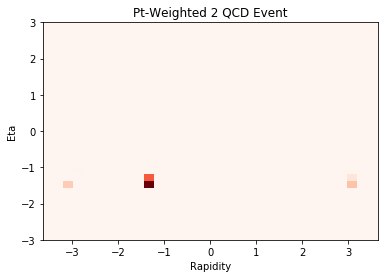

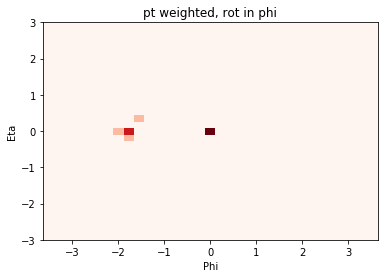

50.0% Processed


In [11]:
f_tracks_hh, f_nHadrons_hh, f_photons_hh    = returnRotatedData( allEvents_hh, 'Dihiggs')
f_tracks_qcd, f_nHadrons_qcd, f_photons_qcd = returnRotatedData( allEvents_qcd, 'QCD')

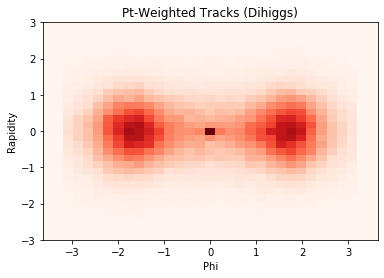

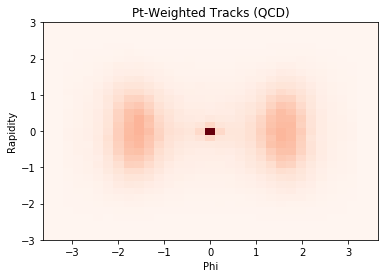

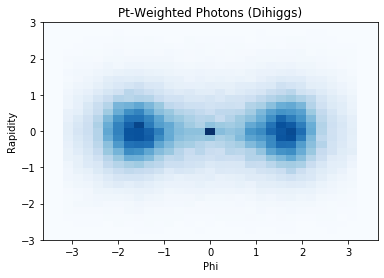

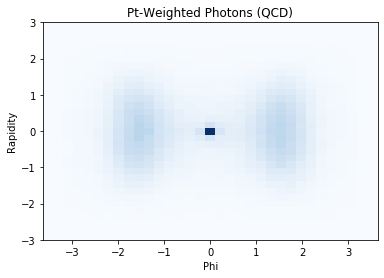

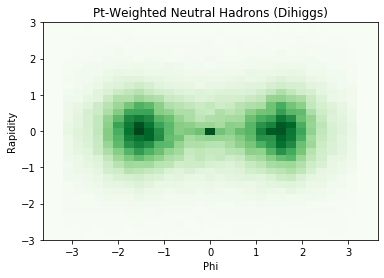

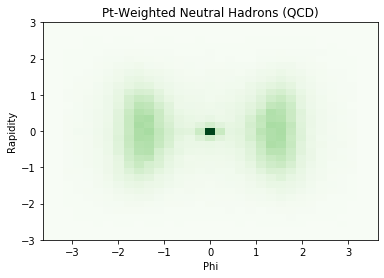

In [12]:
#f_tracks_hh[2][1]
makeSimplePlots( f_tracks_hh, 'Dihiggs', 'Tracks', len(allEvents_hh))
makeSimplePlots( f_tracks_qcd, 'QCD', 'Tracks', len(allEvents_qcd))

makeSimplePlots( f_photons_hh, 'Dihiggs', 'Photons', len(allEvents_hh))
makeSimplePlots( f_photons_qcd, 'QCD', 'Photons', len(allEvents_qcd))

makeSimplePlots( f_nHadrons_hh, 'Dihiggs', 'Neutral Hadrons', len(allEvents_hh))
makeSimplePlots( f_nHadrons_qcd, 'QCD', 'Neutral Hadrons', len(allEvents_qcd))

In [ ]:
print( len(tracks_hh[0]), len(f_tracks_hh[0]))

In [ ]:

# *** Make some event-by-event image plots and also do translation to unified frame
allEta = []
allTheta = []
allPhi = []
allPt  = []
allPtNormed  = []
allPhiTrans  = []
allPhiRot    = []
allEtaRot    = []
allThetaRot    = []

plotOpts = dict(bins=(25, 25), range=[[-1*np.pi-1, np.pi+1],[-5.0, 5.0]], cmap=plt.cm.YlGnBu)

for event in range(0, len(newRows)):
    #if event > 1:
    #    break
    
    _pt    = [ particle[0] for particle in newRows[event] ]
    _eta   = [ particle[1] for particle in newRows[event] ]
    _theta = [ returnTheta(x) for x in _eta ]
    _phi   = [ particle[2] for particle in newRows[event] ]
    _tlv   = [ TLorentzVector.PtEtaPhiMassLorentzVector( particle[0], particle[1], particle[2], 0) for particle in newRows[event] ]
    
    _highestPtIndex = _pt.index(max(_pt))
    _hardestPhi     = _phi[_highestPtIndex]
    _hardestTheta   = returnTheta(_eta[_highestPtIndex])
    #_hardestPhi = np.pi/2
    _hardestTheta = np.pi/4

    ### rotate by phi
    _tlv_rotatedByPhi = getRotatedVectors( _tlv, _angle = _hardestPhi , _axis=[0, 0, 1] )
    _phi_rot = [ tlv.phi for tlv in _tlv_rotatedByPhi ]
    _tlv_rotatedByEta = getRotatedVectors( _tlv_rotatedByPhi, _angle = _hardestTheta , _axis=[-1, 0, 0] )
    #_tlv_rotatedByEta = _tlv_rotatedByPhi
    _eta_rot   = [ tlv.eta for tlv in _tlv_rotatedByEta ]
    _theta_rot = [ returnTheta(tlv.eta) for tlv in _tlv_rotatedByEta ]
  
    
    ###   
    _phi_trans = [ rotatePhi(p_phi, _hardestPhi) for p_phi in _phi ]
    _pt_normed = [ particle[0]/_pt[_highestPtIndex] for particle in newRows[event] ]
    
    #print(max(_pt), _pt[_highestPtIndex], _eta[_highestPtIndex], _phi[_highestPtIndex])
    print(max(_pt), _pt[_highestPtIndex], _tlv[_highestPtIndex].pt, _tlv[_highestPtIndex].eta, _tlv[_highestPtIndex].phi)
    
    
    allPt       += _pt 
    allPtNormed += _pt_normed
    allEta      += _eta 
    allEtaRot   += _eta_rot
    allTheta    += _theta 
    allThetaRot += _theta_rot
    
    allPhi      += _phi
    allPhiTrans += _phi_trans
    allPhiRot   += _phi_rot
    
    plt.hist2d( _phi, _eta, **plotOpts )
    plt.title('Raw Event')
    plt.xlabel('Phi')
    plt.ylabel('Eta')
    plt.show()
    
    plt.hist2d( _phi, _eta, weights=_pt, **plotOpts)
    plt.xlabel('Phi')
    plt.ylabel('Eta')
    plt.title('pt weighted')
    plt.show()
        
    plt.hist2d( _phi_rot, _eta, weights=_pt, **plotOpts)
    plt.title('pt weighted, rot in phi')
    plt.xlabel('Phi')
    plt.ylabel('Eta')
    plt.show()

In [ ]:
cons1 = allEvents_hh[0]['Constituents'][1]
cons2 = allEvents_hh[0]['Constituents'][2]
cons3 = allEvents_hh[0]['Constituents'][3]

allTLVs = [JetCons(jc[0], jc[1], jc[2], jc[3], jc[4]).cons_LVec for jc in allEvents_hh[0]['Constituents']]
v_all = TLorentzVector.PtEtaPhiMassLorentzVector(0,0,0,0)
for tlv in allTLVs:
    v_all += tlv

print("pt: {}, eta: {}, phi: {}, E: {}".format(v_all.pt, v_all.eta, v_all.phi, v_all.E))


In [ ]:
#print(jc.get('rapidity'), cons[2], jc.cons_LVec.rapidity)
#v1 = jc1.cons_LVec
#v2 = jc2.cons_LVec
#v3 = jc3.cons_LVec
v1 = allTLVs[60]
print("pt: {}, eta: {}, phi: {}, E: {}".format(v1.pt, v1.eta, v1.phi, v1.E))
#v_A = v1 + v2 + v3
boost_cms = (v_all.p3/v_all.p3.mag)*v_all.beta
tlvz  = TLorentzVector.TLorentzVector(0,0,v_all.p3.z, v_all.t)
z3    = TVector3.TVector3(0,0,v_all.p3.z )
boost_z   = (z3/tlvz.p3.mag)*tlvz.beta

w1 = v1.boost( boost_back)
w2 = v1.boost( boost_z)
print("pt: {}, eta: {}, phi: {}, E: {}".format(w1.pt, w1.eta, w1.phi, w1.E))
print("pt: {}, eta: {}, phi: {}, E: {}".format(w2.pt, w2.eta, w2.phi, w2.E))
print(v1.rapidity, w1.rapidity, w2.rapidity)
print(v1.phi, w1.phi, w2.phi)
print(v1.pt, w1.pt, w2.pt)

In [ ]:
boost_z

In [ ]:
np.cosh(.76533)